In [11]:
import requests, zipfile, io
import pandas as pd
from bs4 import BeautifulSoup
import re
import datetime as dt  
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import base64
import os
import requests
import json
pd.set_option('display.max_colwidth', -1)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

genius_api_key = os.getenv("GENIUS_ACCESS")

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import sys

import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

spotify_client_id = os.getenv("SPOTIFY_CLIENT_ID")
spotify_client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")
token = os.getenv("SPOTIFY_ACCESS_TOKEN")

In [12]:
filepath = "NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emo_df = emolex_df[((emolex_df.emotion == 'sadness') | (emolex_df.emotion == 'fear')) & (emolex_df.association == 1)]

# This one uses <code>Spotify's API</code>
- retains special info
- refresh my access token every damn hour (https://developer.spotify.com/console/get-track/?id=3n3Ppam7vgaVa1iaRUc9Lp)

In [13]:
token = f"Bearer {token}"
base_url = "https://api.spotify.com/v1"
headers = {'Authorization': token}
search_url = base_url + "/search"

# searching for artists under the emo genre
params = {'q':'genre:emo', 'type':'artist', 'limit': 10}
response = requests.get(search_url, params=params, headers=headers).json()
# print(response)

songs = []
# looping through the emo artist results
for artist in response['artists']['items']:
    row = {}
    
    row['artist_name'] = artist['name']
    row['artist_popularity'] = artist['popularity']
    row['artist_genres'] = artist['genres']
    row['artist_followers'] = artist['followers']['total']
    
#   pulling the artist from the genre search
    base_url = "https://api.spotify.com/v1"
    headers = {'Authorization': token}
    top_tracks_params = {'country':'from_token', 'id': artist['id']}
    top_tracks_search_url = base_url + "/artists/" + artist['id'] + "/top-tracks"
    response_top_tracks = requests.get(top_tracks_search_url, params=top_tracks_params, headers=headers).json()
    for track in response_top_tracks['tracks'][:3]:
        print(artist['name'], "|", track['name'])
        try:
            row['song_album'] = track['album']['name']
        except:
            row['song_album'] = "nan"
        row['song_title'] = track['name']
        row['song_explicit'] = track['explicit']
        row['song_preview_url'] = track['preview_url']
        row['song_popularity'] = track['popularity']
        row['song_id'] = track['id']
         
        search_url = base_url + "/audio-features/" + track['id']
        response_track_features = requests.get(search_url, headers=headers).json()
        for key in response_track_features.keys():
            row[key] = response_track_features[key]
        
#          scraping the lyrics from Genius        
#         genius_base_url = "http://api.genius.com"
#         genius_headers = {'Authorization': f'Bearer {genius_api_key}'}
#         genius_search_url = genius_base_url + "/search"
#         ## searching using the track name
#         genius_params = {'q': track['name']}
#         response_genius = requests.get(genius_search_url, params=genius_params, headers=genius_headers).json()
#         for hit in response_genius['response']['hits'][:1]:
#             row['lyrics_url'] = base_url + hit['result']['path']
            
#             song_path = hit['result']['api_path']
#             headers = {'Authorization': f'Bearer {genius_api_key}'}
#             song_url = genius_base_url + song_path
#             response = requests.get(song_url, headers=headers)
#             json = response.json()
#             path = json["response"]["song"]["path"]
#             page_url = "http://genius.com" + path
#             page = requests.get(page_url)
#             html = BeautifulSoup(page.text, "html.parser")
#             [h.extract() for h in html('script')]
#             lyrics = html.find("div", class_="lyrics").get_text()
#             lyrics = lyrics.replace('\n', ' ')
#             row['lyrics'] = lyrics.lower()
            
            
            songs.append(row)
        
songs_df = pd.DataFrame(songs)

XXXTENTACION | SAD!
XXXTENTACION | Moonlight
XXXTENTACION | Jocelyn Flores
Panic! At The Disco | High Hopes
Panic! At The Disco | ME! (feat. Brendon Urie of Panic! At The Disco)
Panic! At The Disco | Hey Look Ma, I Made It
6ix9ine | FEFE
6ix9ine | BEBE
6ix9ine | KIKA
Fall Out Boy | Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy)
Fall Out Boy | Centuries
Fall Out Boy | Sugar, We're Goin Down
Lil Peep | Falling Down - Bonus Track
Lil Peep | Save That Shit
Lil Peep | Star Shopping
My Chemical Romance | Welcome to the Black Parade
My Chemical Romance | Teenagers
My Chemical Romance | I'm Not Okay (I Promise)
Paramore | Still into You
Paramore | Ain't It Fun
Paramore | Hard Times
iann dior | gone girl
iann dior | emotions
iann dior | molly
Lil Pump | Arms Around You (feat. Maluma & Swae Lee)
Lil Pump | I Love It (& Lil Pump)
Lil Pump | Gucci Gang
Josh A | Suicidal Thoughts
Josh A | Gucci Coffin
Josh A | Endless Nightmare


In [5]:
songs_df.to_csv('spotify_genre_emo.csv', index=False)

In [3]:
songs_df = pd.read_csv('spotify_genre_emo.csv')
songs_df.sort_values('artist_popularity', ascending=False).artist_name.unique()

array(['XXXTENTACION', 'Panic! At The Disco', 'Fall Out Boy', 'Lil Peep',
       '6ix9ine', 'Lil Pump', 'Paramore', 'My Chemical Romance',
       'iann dior', 'Josh A'], dtype=object)

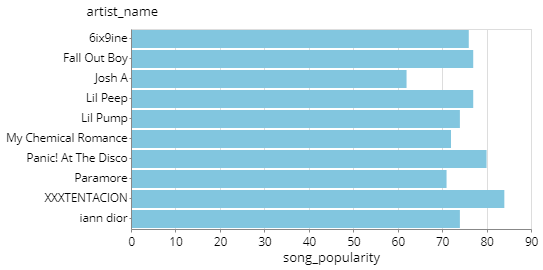

In [53]:
pop_df = pd.DataFrame(songs_df.groupby('artist_name').song_popularity.mean().sort_values(ascending=False).reset_index())
chart = alt.Chart(pop_df,width=400, height=200).mark_bar().encode(x='song_popularity', y='artist_name')


In [86]:
# client_credentials_manager = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret)
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# base_url = "https://api.spotify.com/v1"
# search_url = base_url + "/search"
# # headers = {'Authorization': f"Bearer {spotify_api_key}"}
# # params = {'q': 'genre:emo', 'type': 'artist', 'limit': 1}

# response = sp.search(q='genre:emo', type='artist', limit=1)

# songs = []
# for artist in response['artists']['items']:
#     row = {}
    
#     row['artist_name'] = artist['name']
#     row['artist_popularity'] = artist['popularity']
#     row['artist_genres'] = artist['genres']
    
# #     set up to iterate only through the first track
#     for song in sp.artist_top_tracks(artist['id'], country='US')['tracks'][:2]:
# #         print(song)
#         row['title'] = song['name']
#         row['explicit'] = song['explicit']
#         row['preview'] = song['preview_url']
#         row['popularity'] = song['popularity']
        
#         print(artist['name'], "|", song['name'])
        
#         response_track_features = sp.audio_features(tracks=song['id'])
#         for features in response_track_features:
#             for feature in features.keys():
#                 row[feature] = features[feature]
#             print(sp.track(features['uri']))
            
# #         base_url = "http://api.genius.com"
# #         headers = {'Authorization': f'Bearer {genius_api_key}'}
# #         search_url = base_url + "/search"
# #         artist_name = artist['name']
# #         song_title = song['name']
# #         params = {'q': artist_name + song_title}
# #         response = requests.get(search_url, params=params, headers=headers).json()
# #         for song in response['response']['hits'][:1]:

# #         #     getting some of the meta data
# #             row['lyrics_url'] = base_url + song['result']['path']
            
# #         #  scraping the lyrics from genius
# #             base_url = "http://api.genius.com"
# #             song_path = song['result']['api_path']
# #             headers = {'Authorization': f'Bearer {genius_api_key}'}
# #             song_url = base_url + song_path
# #             response = requests.get(song_url, headers=headers)
# #             json = response.json()
# #             path = json["response"]["song"]["path"]
# #             page_url = "http://genius.com" + path
# #             page = requests.get(page_url)
# #             html = BeautifulSoup(page.text, "html.parser")
# #             [h.extract() for h in html('script')]
# #             lyrics = html.find("div", class_="lyrics").get_text()
# #             lyrics = lyrics.replace('\n', ' ')
# #             row['lyrics'] = lyrics.lower()

#         #     throw it in the dictionary
# #             songs.append(row)
# #             print(f"Grabbing the lyrics for {song['result']['primary_artist']['name']}, {song['result']['title_with_featured']}")

XXXTENTACION | SAD!
{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/15UsOTVnJzReFVN1VCnxy4'}, 'href': 'https://api.spotify.com/v1/artists/15UsOTVnJzReFVN1VCnxy4', 'id': '15UsOTVnJzReFVN1VCnxy4', 'name': 'XXXTENTACION', 'type': 'artist', 'uri': 'spotify:artist:15UsOTVnJzReFVN1VCnxy4'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/2Ti79nwTsont5ZHfdxIzAm'}, 'href': 'https://api.spotify.com/v1/albums/2Ti79nwTsont5ZHfdxIzAm', 

In [77]:
for song in songs:
    print(song['preview'])

None
None
None
None
https://p.scdn.co/mp3-preview/bda115bbf4f1de770a9809a2d28dbde92b00b208?cid=de12d73a562343b68e7a6516e08da5fd
https://p.scdn.co/mp3-preview/bda115bbf4f1de770a9809a2d28dbde92b00b208?cid=de12d73a562343b68e7a6516e08da5fd
None
https://p.scdn.co/mp3-preview/8058676c82db42a04ceceb90826af22f7726768a?cid=de12d73a562343b68e7a6516e08da5fd


In [4]:
# setting up the api search w/ the artist I'm looking for
base_url = "http://api.genius.com"
headers = {'Authorization': f'Bearer {genius_api_key}'}
search_url = base_url + "/search"
artist_name = artist['name']
song_title = song['name']
params = {'q': artist_name}
response = requests.get(search_url, params=params, headers=headers).json()

songs = []
for song in response['response']['hits']:
    song_dict = {}
    
#     getting some of the meta data
    song_dict['artist'] = song['result']['primary_artist']['name']
    song_dict['title'] = song['result']['title_with_featured']
    song_dict['api_path'] = base_url + song['result']['api_path']
    song_dict['album_art'] = song['result']['header_image_url']
    song_dict['lyrics_url'] = base_url + song['result']['path']
    
#  scraping the lyrics
    base_url = "http://api.genius.com"
    song_path = song['result']['api_path']
    headers = {'Authorization': f'Bearer {genius_api_key}'}
    song_url = base_url + song_path
    response = requests.get(song_url, headers=headers)
    json = response.json()
    path = json["response"]["song"]["path"]
    page_url = "http://genius.com" + path
    page = requests.get(page_url)
    html = BeautifulSoup(page.text, "html.parser")
    [h.extract() for h in html('script')]
    lyrics = html.find("div", class_="lyrics").get_text()
    lyrics = lyrics.replace('\n', ' ')
    song_dict['lyrics'] = lyrics.lower()
    
#     throw it in the dictionary
    songs.append(song_dict)
    print(f"Grabbing the lyrics for {song['result']['primary_artist']['name']}, {song['result']['title_with_featured']}")

Grabbing the lyrics for Lil Peep, Star Shopping
Grabbing the lyrics for Lil Peep & XXXTENTACION, Falling Down
Grabbing the lyrics for Lil Peep, Save That Shit
Grabbing the lyrics for Lil Peep, Benz Truck (Гелик)
Grabbing the lyrics for Lil Peep & Lil Tracy, Witchblades
Grabbing the lyrics for Lil Peep, Awful Things (Ft. Lil Tracy)
Grabbing the lyrics for Lil Peep, ​Beamer Boy
Grabbing the lyrics for Marshmello & Lil Peep, Spotlight
Grabbing the lyrics for Lil Peep, Crybaby
Grabbing the lyrics for Lil Peep & Lil Tracy, ​White Wine


In [67]:
songs_df = pd.DataFrame(songs)
print(songs_df.head(1).lyrics)
songs_df.head(1).lyrics.str.replace('\[\w+: \]','', regex=True)

0      [intro: shiloh dynasty] i know you so well, so well i mean, i can do anything that he can i've been pretty—  [bridge: xxxtentacion & shiloh dynasty] i know you're somewhere, somewhere i've been trapped in my mind, girl, just holding on i don't wanna pretend we're something, we're nothing i've been stuck thinking 'bout her, i can't hold on (i'll be feeling)  [verse: xxxtentacion] i'm in pain, wanna put ten shots in my brain i've been trippin' 'bout some things, can't change suicidal, same time i'm tame picture this, in bed, get a phone call girl that you fucked with killed herself that was this summer when nobody helped and ever since then, man, i hate myself wanna fuckin' end it, pessimistic all wanna see me with no pot to piss in but niggas been excited 'bout the grave i'm diggin' havin' conversations 'bout my haste decisions fuckin' sickenin'; at the same time memories surface through the grapevine 'bout my uncle playin' with a slip knot post-traumatic stress got me fucked up 

0      [intro: shiloh dynasty] i know you so well, so well i mean, i can do anything that he can i've been pretty—  [bridge: xxxtentacion & shiloh dynasty] i know you're somewhere, somewhere i've been trapped in my mind, girl, just holding on i don't wanna pretend we're something, we're nothing i've been stuck thinking 'bout her, i can't hold on (i'll be feeling)  [verse: xxxtentacion] i'm in pain, wanna put ten shots in my brain i've been trippin' 'bout some things, can't change suicidal, same time i'm tame picture this, in bed, get a phone call girl that you fucked with killed herself that was this summer when nobody helped and ever since then, man, i hate myself wanna fuckin' end it, pessimistic all wanna see me with no pot to piss in but niggas been excited 'bout the grave i'm diggin' havin' conversations 'bout my haste decisions fuckin' sickenin'; at the same time memories surface through the grapevine 'bout my uncle playin' with a slip knot post-traumatic stress got me fucked up 

In [9]:
for word in emo_df.word:
    if re.findall(word, songs_df.lyrics[0]) != []:
        print(f"{word} shows up {len(re.findall(word, songs_df.lyrics[0]))} time")

art shows up 1 time
elf shows up 1 time
fall shows up 2 time
music shows up 1 time
rot shows up 1 time
rot shows up 1 time
sin shows up 1 time
sin shows up 1 time
wan shows up 1 time
wan shows up 1 time


In [189]:
songs_df.lyrics.str.replace('\[.+\]', '', regex=True)

0       Look at the sky tonight, all of the stars have a reason A reason to shine, a reason like mine and I'm fallin' to pieces Look at the sky tonight, all of the stars have a reason                                                                                                                                                                                                             
1       Come, let's watch the rain as it's falling down Oh-oh-oh, oh-oh, oh-oh Sunlight on your skin when I'm not around, yeah Oh-oh-oh, oh-oh, oh-oh Shit don't feel the same when you're out of town Oh-oh-oh, oh-oh, oh-oh So come, let's watch the rain as it's falling down Oh-oh-oh, oh-oh, oh-oh                                                                                             
2       Do I make you scared? Baby, won't you take me back? Nothin' like them other mothafuckas' I can make you rich (I can make you rich)                                                                                    

In [185]:
songs_df.api_url

0    http://api.genius.com/songs/2353006
1    http://api.genius.com/songs/3906162
2    http://api.genius.com/songs/3175124
3    http://api.genius.com/songs/3117098
4    http://api.genius.com/songs/2977800
5    http://api.genius.com/songs/3121880
6    http://api.genius.com/songs/2430998
7    http://api.genius.com/songs/3384913
8    http://api.genius.com/songs/2496168
9    http://api.genius.com/songs/2814605
Name: api_url, dtype: object

## Trying to get punk songs!



In [32]:
access_token = os.getenv("SPOTIFY_ACCESS_TOKEN")
token = f"Bearer {access_token}"
base_url = "https://api.spotify.com/v1"
headers = {'Authorization': token}
search_url = base_url + "/search"

# searching for artists under the emo genre
params = {'q':'punk', 'type':'playlist', 'market':'us', 'limit':50}
response = requests.get(search_url, params=params, headers=headers).json()

for item in response['playlists']['items']:
    if item['owner']['display_name'] == "Spotify":
        print(item['name'])
        print(item['external_urls']['spotify'])
        print(item['tracks']['href'])
        print(item['tracks']['total'])
        playlist_response = requests.get(item['tracks']['href'],headers=headers).json()
        for asdf item['items']:
            print()
        print("==========================================================================")

Punk Essentials
https://open.spotify.com/playlist/37i9dQZF1DXd6tJtr4qeot
https://api.spotify.com/v1/playlists/37i9dQZF1DXd6tJtr4qeot/tracks
50
[{'added_at': '2019-08-24T01:08:30Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/7qpy5KY3DVrezixTl6mziA'}, 'href': 'https://api.spotify.com/v1/artists/7qpy5KY3DVrezixTl6mziA', 'id': '7qpy5KY3DVrezixTl6mziA', 'name': 'Propagandhi', 'type': 'artist', 'uri': 'spotify:artist:7qpy5KY3DVrezixTl6mziA'}], 'available_markets': [], 'external_urls': {'spotify': 'https://open.spotify.com/album/6O7bulB3H5qfZPgpP6VRHp'}, 'href': 'https://api.spotify.com/v1/albums/6O7bulB3H5qfZPgpP6VRHp', 'id': '6O7bulB3H5qfZPgpP6VRHp', 'images': [{'height': 640, 'url': 'https://i.scdn.co/ima

[{'added_at': '2019-02-05T21:18:44Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2fhngmJMaaKcdhXHCa4cPK'}, 'href': 'https://api.spotify.com/v1/artists/2fhngmJMaaKcdhXHCa4cPK', 'id': '2fhngmJMaaKcdhXHCa4cPK', 'name': 'The Dead Milkmen', 'type': 'artist', 'uri': 'spotify:artist:2fhngmJMaaKcdhXHCa4cPK'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 

[{'added_at': '2019-02-05T20:12:21Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/24XtlMhEMNdi822vi0MhY1'}, 'href': 'https://api.spotify.com/v1/artists/24XtlMhEMNdi822vi0MhY1', 'id': '24XtlMhEMNdi822vi0MhY1', 'name': 'Taking Back Sunday', 'type': 'artist', 'uri': 'spotify:artist:24XtlMhEMNdi822vi0MhY1'}], 'available_markets': [], 'external_urls': {'spotify': 'https://open.spotify.com/album/6OWxP59cOtitg0ALmbms8e'}, 'href': 'https://api.spotify.com/v1/albums/6OWxP59cOtitg0ALmbms8e', 'id': '6OWxP59cOtitg0ALmbms8e', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/cfbc3a8449819cbc07413449529e0ac174793671', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/bda12d9d5b01ad03e345c4f7a34

[{'added_at': '2019-08-24T00:47:18Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5rx7lpIuya41ws2oWXRiGu'}, 'href': 'https://api.spotify.com/v1/artists/5rx7lpIuya41ws2oWXRiGu', 'id': '5rx7lpIuya41ws2oWXRiGu', 'name': 'Larry and His Flask', 'type': 'artist', 'uri': 'spotify:artist:5rx7lpIuya41ws2oWXRiGu'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY

[{'added_at': '2019-08-30T21:04:56Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/05DSiNi8z8w8iXz34JfHse'}, 'href': 'https://api.spotify.com/v1/artists/05DSiNi8z8w8iXz34JfHse', 'id': '05DSiNi8z8w8iXz34JfHse', 'name': 'Punk Goes', 'type': 'artist', 'uri': 'spotify:artist:05DSiNi8z8w8iXz34JfHse'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', '

[{'added_at': '2019-09-18T03:47:18Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5rJVTTK0ucAxQhkUc0nXbH'}, 'href': 'https://api.spotify.com/v1/artists/5rJVTTK0ucAxQhkUc0nXbH', 'id': '5rJVTTK0ucAxQhkUc0nXbH', 'name': 'Tiny Moving Parts', 'type': 'artist', 'uri': 'spotify:artist:5rJVTTK0ucAxQhkUc0nXbH'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY'

[{'added_at': '2019-09-21T02:05:46Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/62elZbH5Iop8UPcChp7OrU'}, 'href': 'https://api.spotify.com/v1/artists/62elZbH5Iop8UPcChp7OrU', 'id': '62elZbH5Iop8UPcChp7OrU', 'name': "Can't Swim", 'type': 'artist', 'uri': 'spotify:artist:62elZbH5Iop8UPcChp7OrU'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 

[{'added_at': '2019-09-21T02:02:14Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/16QCJENzcdhwka9bTKYMVB'}, 'href': 'https://api.spotify.com/v1/artists/16QCJENzcdhwka9bTKYMVB', 'id': '16QCJENzcdhwka9bTKYMVB', 'name': 'Touché Amoré', 'type': 'artist', 'uri': 'spotify:artist:16QCJENzcdhwka9bTKYMVB'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA

[{'added_at': '2019-09-12T22:01:00Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3vHlZN6pTa2zOl2eVxiEdJ'}, 'href': 'https://api.spotify.com/v1/artists/3vHlZN6pTa2zOl2eVxiEdJ', 'id': '3vHlZN6pTa2zOl2eVxiEdJ', 'name': 'La Polla Records', 'type': 'artist', 'uri': 'spotify:artist:3vHlZN6pTa2zOl2eVxiEdJ'}], 'available_markets': ['AD', 'AE', 'AT', 'AU', 'BE', 'BG', 'BH', 'CA', 'CH', 'CY', 'CZ', 'DE', 'DK', 'DZ', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HK', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MY', 'NL', 'NO', 'NZ', 'OM', 'PH', 'PL', 'PS', 'PT', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'TH', 'TN', 'TR', 'TW', 'US', 'VN', 'ZA'], 'external_u

[{'added_at': '2019-09-14T12:57:45Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2TM0qnbJH4QPhGMCdPt7fH'}, 'href': 'https://api.spotify.com/v1/artists/2TM0qnbJH4QPhGMCdPt7fH', 'id': '2TM0qnbJH4QPhGMCdPt7fH', 'name': 'Neck Deep', 'type': 'artist', 'uri': 'spotify:artist:2TM0qnbJH4QPhGMCdPt7fH'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 

[{'added_at': '2019-08-30T18:02:35Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2PvllJTBKE17fG2ltGAGL8'}, 'href': 'https://api.spotify.com/v1/artists/2PvllJTBKE17fG2ltGAGL8', 'id': '2PvllJTBKE17fG2ltGAGL8', 'name': 'Vidro', 'type': 'artist', 'uri': 'spotify:artist:2PvllJTBKE17fG2ltGAGL8'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO'

[{'added_at': '2019-09-20T04:01:00Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6FBDaR13swtiWwGhX1WQsP'}, 'href': 'https://api.spotify.com/v1/artists/6FBDaR13swtiWwGhX1WQsP', 'id': '6FBDaR13swtiWwGhX1WQsP', 'name': 'blink-182', 'type': 'artist', 'uri': 'spotify:artist:6FBDaR13swtiWwGhX1WQsP'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', '

[{'added_at': '2019-09-17T15:01:00Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6YqdtpUutxodni6lUD4stM'}, 'href': 'https://api.spotify.com/v1/artists/6YqdtpUutxodni6lUD4stM', 'id': '6YqdtpUutxodni6lUD4stM', 'name': 'WANIMA', 'type': 'artist', 'uri': 'spotify:artist:6YqdtpUutxodni6lUD4stM'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA

[{'added_at': '2019-09-21T01:50:21Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5rJVTTK0ucAxQhkUc0nXbH'}, 'href': 'https://api.spotify.com/v1/artists/5rJVTTK0ucAxQhkUc0nXbH', 'id': '5rJVTTK0ucAxQhkUc0nXbH', 'name': 'Tiny Moving Parts', 'type': 'artist', 'uri': 'spotify:artist:5rJVTTK0ucAxQhkUc0nXbH'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY',

[{'added_at': '2019-07-25T01:32:07Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3DZM1ODnTL003kSGHSd7dA'}, 'href': 'https://api.spotify.com/v1/artists/3DZM1ODnTL003kSGHSd7dA', 'id': '3DZM1ODnTL003kSGHSd7dA', 'name': 'Camiches', 'type': 'artist', 'uri': 'spotify:artist:3DZM1ODnTL003kSGHSd7dA'}], 'available_markets': [], 'external_urls': {'spotify': 'https://open.spotify.com/album/0ZeUtkRCM2BQVYsGXG7iac'}, 'href': 'https://api.spotify.com/v1/albums/0ZeUtkRCM2BQVYsGXG7iac', 'id': '0ZeUtkRCM2BQVYsGXG7iac', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/cef0e44d9a995fb56d6fcea6a03c249a89f802b4', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/78277ca20031d27aac3636d9b3b104d21d9b5

[{'added_at': '2018-09-03T10:50:19Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5H32ktDvTByY5e4zJpfFTa'}, 'href': 'https://api.spotify.com/v1/artists/5H32ktDvTByY5e4zJpfFTa', 'id': '5H32ktDvTByY5e4zJpfFTa', 'name': 'Iron Chic', 'type': 'artist', 'uri': 'spotify:artist:5H32ktDvTByY5e4zJpfFTa'}], 'available_markets': [], 'external_urls': {'spotify': 'https://open.spotify.com/album/0M5wuBh1t18dtOjl8wwe7T'}, 'href': 'https://api.spotify.com/v1/albums/0M5wuBh1t18dtOjl8wwe7T', 'id': '0M5wuBh1t18dtOjl8wwe7T', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/c5094bf7818ab9e9afad803d8722f9522ef81008', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/998cbd3cfbb5494589628c3c2cd5ce1b8ce4

[{'added_at': '2019-08-01T09:13:54Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/432R46LaYsJZV2Gmc4jUV5'}, 'href': 'https://api.spotify.com/v1/artists/432R46LaYsJZV2Gmc4jUV5', 'id': '432R46LaYsJZV2Gmc4jUV5', 'name': 'Joy Division', 'type': 'artist', 'uri': 'spotify:artist:432R46LaYsJZV2Gmc4jUV5'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PT', 'PY', 'QA', 'RO', 'SA'

[{'added_at': '2019-09-21T01:56:49Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6A7uqgC2N1nUhrCLAytHxN'}, 'href': 'https://api.spotify.com/v1/artists/6A7uqgC2N1nUhrCLAytHxN', 'id': '6A7uqgC2N1nUhrCLAytHxN', 'name': 'PUP', 'type': 'artist', 'uri': 'spotify:artist:6A7uqgC2N1nUhrCLAytHxN'}], 'available_markets': ['CA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/0819j23RlVKRJLnXM8ZQI3'}, 'href': 'https://api.spotify.com/v1/albums/0819j23RlVKRJLnXM8ZQI3', 'id': '0819j23RlVKRJLnXM8ZQI3', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/b17345c68207e20755c7920b9ecc0d3657ef6ecd', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/53ffa8e97c4482b886f96fe39d75c7a5d22d3d

[{'added_at': '2019-07-29T08:01:00Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5bdYPMK2KCKXmWunHHiRN0'}, 'href': 'https://api.spotify.com/v1/artists/5bdYPMK2KCKXmWunHHiRN0', 'id': '5bdYPMK2KCKXmWunHHiRN0', 'name': 'Tagada Jones', 'type': 'artist', 'uri': 'spotify:artist:5bdYPMK2KCKXmWunHHiRN0'}], 'available_markets': ['AD', 'AE', 'AR', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG'

[{'added_at': '2019-08-02T16:44:23Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/18M7pJRsgFVjEBZ5ufmJAp'}, 'href': 'https://api.spotify.com/v1/artists/18M7pJRsgFVjEBZ5ufmJAp', 'id': '18M7pJRsgFVjEBZ5ufmJAp', 'name': 'The Murder Capital', 'type': 'artist', 'uri': 'spotify:artist:18M7pJRsgFVjEBZ5ufmJAp'}], 'available_markets': [], 'external_urls': {'spotify': 'https://open.spotify.com/album/5yM1tyAoWPEuY4j6OTZo8b'}, 'href': 'https://api.spotify.com/v1/albums/5yM1tyAoWPEuY4j6OTZo8b', 'id': '5yM1tyAoWPEuY4j6OTZo8b', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/47af5181964e1329377076e0127d86227991da52', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/5fe4f1784f8d68e94fa7aa5f6e

[{'added_at': '2019-06-19T09:34:31Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1SQRv42e4PjEYfPhS0Tk9E'}, 'href': 'https://api.spotify.com/v1/artists/1SQRv42e4PjEYfPhS0Tk9E', 'id': '1SQRv42e4PjEYfPhS0Tk9E', 'name': 'The Kinks', 'type': 'artist', 'uri': 'spotify:artist:1SQRv42e4PjEYfPhS0Tk9E'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', '

[{'added_at': '2019-08-13T08:29:32Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1nJvji2KIlWSseXRSlNYsC'}, 'href': 'https://api.spotify.com/v1/artists/1nJvji2KIlWSseXRSlNYsC', 'id': '1nJvji2KIlWSseXRSlNYsC', 'name': 'The Velvet Underground', 'type': 'artist', 'uri': 'spotify:artist:1nJvji2KIlWSseXRSlNYsC'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 

[{'added_at': '2019-02-05T21:07:48Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/432R46LaYsJZV2Gmc4jUV5'}, 'href': 'https://api.spotify.com/v1/artists/432R46LaYsJZV2Gmc4jUV5', 'id': '432R46LaYsJZV2Gmc4jUV5', 'name': 'Joy Division', 'type': 'artist', 'uri': 'spotify:artist:432R46LaYsJZV2Gmc4jUV5'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PT', 'PY', 'QA', 'RO', 'SA'

[{'added_at': '2019-07-10T15:28:38Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WaJSfKnzc65VDgmj2zU8B'}, 'href': 'https://api.spotify.com/v1/artists/3WaJSfKnzc65VDgmj2zU8B', 'id': '3WaJSfKnzc65VDgmj2zU8B', 'name': 'Interpol', 'type': 'artist', 'uri': 'spotify:artist:3WaJSfKnzc65VDgmj2zU8B'}], 'available_markets': ['AE', 'AR', 'AU', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'DO', 'DZ', 'EC', 'EG', 'FI', 'GB', 'GT', 'HK', 'HN', 'ID', 'IL', 'IN', 'IS', 'JO', 'JP', 'KW', 'LB', 'MA', 'MX', 'MY', 'NI', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PY', 'QA', 'SA', 'SE', 'SG', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/58fDEyJ5XSau8FRA3y